# Load Library

In [1]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from model_utils import train_torch_model, test_torch_model, port_mlp_to_ch
from data_utils import oneHotCatVars
from whitebox_attack import neuron_output, make_neuron_output_data, roc_curve_plot, get_LOMIA_case_1_correct_examples, Top10CorrNeurons, wb_corr_attacks
from disparate_vulnerability_utils import get_accuracy, get_indices_by_conditions, subgroup_vulnerability_distance_vector, subgroup_vulnerability_distance, get_subgroup_disparity, plot_subgroup_disparity, improved_subgroup_attack, get_subgroup_disparity_baseline, get_top_dist_indices
import shap
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import tabulate
# import utils

/Users/ehsanulkabir/miniconda/envs/tabular/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
ds = data_utils.CensusWrapper(
            filter_prop="none", ratio=float(0.5), split="all", name="GSS")
(x_tr, y_tr), (x_te, y_te), cols = ds.load_data()
X_train = pd.DataFrame(x_tr, columns=cols)

In [ ]:
def filter_random_data(ds, clf, confidence_threshold=0.99, num_samples=100000, seed=42):
    def oneHotCatVars(x, colname):
        df_1 = x.drop(columns=colname, axis=1)
        df_2 = pd.get_dummies(x[colname], prefix=colname, prefix_sep='_')
        return (pd.concat([df_1, df_2], axis=1, join='inner'))

    random_df, random_oh_df = ds.ds.get_random_data(num_samples)
    data_dict = ds.ds.meta
    X_random = random_oh_df.drop(data_dict['y_column'], axis=1)
    default_cols = X_random.columns
    # y = random_oh_df[data_dict['y_column']]

    sensitive_attr = data_dict['sensitive_column']
    sensitive_values = data_dict['sensitive_values']
    prediction_columns = []
    for sensitive_value in sensitive_values:
        X_random[sensitive_attr + "_" + sensitive_value] = pd.Series(np.ones(X_random.shape[0]), index=X_random.index)
        for other_value in sensitive_values:
            if other_value != sensitive_value:
                X_random[sensitive_attr + "_" + other_value] = pd.Series(np.zeros(X_random.shape[0]), index=X_random.index)

        newcolname = "prediction_" + sensitive_value
        prediction_columns.append(newcolname)
        X_random[newcolname] = pd.Series(np.argmax(clf.predict(X_random[default_cols]), axis=1), index=X_random.index)
        X_random["confidence_" + sensitive_value] = pd.Series(np.max(clf.predict_proba(X_random[default_cols]), axis=1), 
                                                            index=X_random.index)

    X_random['all_predictions'] = X_random[prediction_columns].apply(pd.Series.unique, axis=1)

    # X_random = X_random[X_random['all_predictions'].apply(lambda x: len(x)==len(sensitive_values))]


    dfs = []

    for sensitive_value in sensitive_values:
        X_temp = X_random[default_cols].copy()

        X_temp[sensitive_attr + "_" + sensitive_value] = pd.Series(np.ones(X_temp.shape[0]), index=X_random.index)
        for other_value in sensitive_values:
            if other_value != sensitive_value:
                X_temp[sensitive_attr + "_" + other_value] = pd.Series(np.zeros(X_temp.shape[0]), index=X_random.index)

        X_temp[data_dict['y_column']] = X_random["prediction_" + sensitive_value].apply(lambda x: data_dict['y_values'][x])
        X_temp['confidence'] = X_random["confidence_" + sensitive_value]

        dfs.append(X_temp.copy())

    random_oh_df = pd.concat(dfs, ignore_index=True)

    random_oh_df = random_oh_df[random_oh_df['confidence'].apply(lambda x: x > confidence_threshold)].drop('confidence', axis=1)

    random_oh_df = oneHotCatVars(random_oh_df, data_dict['y_column'])

    #convert datatype to float
    random_oh_df = random_oh_df.astype(float)

    return random_oh_df

    

# Load and Train Target Model

In [3]:
load_model = True
save_model = False

if load_model:
    clf = model_utils.load_model(f'<PATH_TO_MODEL>/{ds.ds.name}_target_model.pkl')
else:
    clf = model_utils.get_model(max_iter=500)
    y_tr_onehot = ds.ds.y_enc.transform(y_tr).toarray()
    clf.fit(X_train, y_tr_onehot)

    if save_model:
        model_utils.save_model(clf, f'<PATH_TO_MODEL>/{ds.ds.name}_target_model.pkl')

# Test Target Model

In [4]:
# train_acc = 100 * clf.score(x_tr, y_tr.ravel())
# test_acc = 100 * clf.score(x_te, y_te.ravel())
train_acc = 100 * clf.score(X_train, ds.ds.y_enc.transform(y_tr).toarray())
test_acc = 100 * clf.score(x_te, ds.ds.y_enc.transform(y_te).toarray())
if True:
    print("Classifier: Train acc %.2f , Test acc %.2f\n" %
            (train_acc, test_acc))

Classifier: Train acc 67.01 , Test acc 56.86



X does not have valid feature names, but MLPClassifier was fitted with feature names


# Convert to PyTorch Model

In [ ]:
target_model = port_mlp_to_ch(clf)

In [ ]:
target_model = train_torch_model(target_model, x_tr, y_tr_onehot, epochs=10000, lr = 0.01)

In [ ]:
y_te_onehot = ds.ds.y_enc.transform(y_te).toarray()
test_acc = test_torch_model(target_model, x_te, y_te_onehot)
print("Classifier: Test acc %.2f\n" % (test_acc))

# LOMIA Attack

In [ ]:
attack_dataset = model_utils.LOMIA_attack(clf, X_train, y_tr, ds.ds.meta)

In [ ]:
attack_df = pd.concat(attack_dataset)
attack_df[ds.ds.meta['y_column']] = attack_df[ds.ds.meta['y_column']].apply(lambda x: ds.ds.meta['y_values'][x])

In [ ]:
attack_df.to_csv('<PATH_TO_DATASET>/GSS_attack.csv')

# Load Attack Data

In [ ]:
attack_df = pd.read_csv(f'<PATH_TO_DATASET>/{ds.ds.name}_attack.csv')
attack_df.index = attack_df['Unnamed: 0']
attack_df.index.name = None
attack_df = attack_df.drop('Unnamed: 0', axis=1)

In [ ]:
# Split the DataFrame into input and output variables
X_attack = attack_df.drop([ds.ds.meta['sensitive_column'] + "_" + val for val in ds.ds.meta['sensitive_values']], axis=1) 
X_attack = oneHotCatVars(X_attack, ds.ds.meta['y_column'])
y_attack = attack_df[[ ds.ds.meta['sensitive_column'] + "_" + ds.ds.meta['sensitive_positive']]]
# y_attack_onehot, att_enc = onehot(y_attack.to_numpy())
y_attack_onehot = ds.ds.sensitive_enc.transform(y_attack.to_numpy()).toarray()

# Train Attack Model

In [ ]:
attack_clf = model_utils.get_model(max_iter=500)

In [ ]:
attack_clf.fit(X_attack, y_attack_onehot)

In [ ]:
X, y = ds.ds.get_attack_df()
# Convert X to float
X = X.astype(float)

X_tensor = torch.from_numpy(X.to_numpy()).float().to(model_utils.device)

In [ ]:
acc = 100 * attack_clf.score(X, ds.ds.sensitive_enc.transform(y.to_numpy().ravel().reshape(-1, 1)).toarray())
if True:
    print(f"Attack accuracy: {acc}")

In [ ]:
attack_model = model_utils.port_mlp_to_ch(attack_clf)

In [ ]:
predictions = attack_model(X_tensor)
# calculate accuracy
correct = 0
total = 0
with torch.no_grad():
    for i in range(len(X_tensor)):
        if predictions[i].argmax().item() == y.iloc[i].astype(int):
            correct += 1
        total += 1

print(f'Accuracy of the network on the {len(X_tensor)} test images: {100 * correct / total} %')

# Model Inversion with Full Records

In [13]:
X, y = ds.ds.get_attack_df()
# Convert X to float
X = X.astype(float)
y_onehot = ds.ds.sensitive_enc.transform(y.to_numpy().ravel().reshape(-1, 1)).toarray()

In [11]:
load_model = True
save_model = False

if load_model:
    inv_clfs = model_utils.load_model(f'<PATH_TO_MODEL>/{ds.ds.name}_inverse_model.pkl')
else:

    inv_clfs = {}

    for test_size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        x_tr, x_te, y_tr, y_te = train_test_split(X, y_onehot, test_size=test_size, random_state=42)

        inv_clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(60, 50, 40, 30, 20, 10))
        inv_clf.fit(x_tr, y_tr)
        inv_clfs[test_size] = inv_clf

        acc = 100 * inv_clf.score(x_te, y_te)
        print(f'Inverse accuracy with test size {test_size}: {acc}')

    if save_model:
        model_utils.save_model(inv_clfs, f'<PATH_TO_MODEL>/{ds.ds.name}_inverse_model.pkl')

In [12]:
for test_size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    x_tr, x_te, y_tr, y_te = train_test_split(X, y_onehot, test_size=test_size, random_state=42)

    inv_clf = inv_clfs[test_size]
    
    # calculate auc
    y_pred = inv_clf.predict_proba(x_te)
    auc = roc_auc_score(y_te, y_pred)
    print(f'AUC with test size {test_size}: {auc}')

AUC with test size 0.1: 0.6757753072866576
AUC with test size 0.2: 0.6839158131006575
AUC with test size 0.3: 0.7041849180161708
AUC with test size 0.4: 0.6692032411039254
AUC with test size 0.5: 0.6554163416833265
AUC with test size 0.6: 0.6655542502660508
AUC with test size 0.7: 0.6443314578592082
AUC with test size 0.8: 0.6228455643768328
AUC with test size 0.9: 0.617396575193147


In [21]:
aucs[5:-1]

[0.6110328277638002,
 0.6128326834744925,
 0.6238416054389216,
 0.6265131528077251,
 0.6405532666453324]

# Init Shap JS visualization

In [ ]:
shap.initjs()

# Target Model Shapley Plot

In [ ]:
def f(X):
    # X_tensor = torch.from_numpy(X.to_numpy()).float().to(model_utils.device)
    X_tensor = torch.from_numpy(X).float().to(model_utils.device)
    predictions = target_model(X_tensor)
    # predictions is of shape (batch_size, 2) and contains the logits
    # for each data point in the batch, we need to return the class with the highest probability
    # we can do this by taking the argmax of the logits
    return predictions.argmax(dim=1).detach().cpu().numpy()

In [ ]:
K = 100 # Number of samples to use for background data
background = shap.kmeans(X_train, K)

In [ ]:
explainer = shap.KernelExplainer(f, background)

In [ ]:
# explainer.shap_values(X_train.iloc[0])
shap_values50 = explainer.shap_values(X_train.iloc[280:330,:], nsamples=500)

In [ ]:
X_display = ds.ds.original_df

In [ ]:
pd.crosstab(X_display['marital'], X_display['income'])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values50, X_display.iloc[280:330,:])

In [ ]:
explainer(X_train)

In [ ]:
explainer(x_tr)

# Attack Model Shapley Plot

In [ ]:
def attack_f(X):
    X_tensor = torch.from_numpy(X).float().to(model_utils.device)
    predictions = attack_model(X_tensor)
    # predictions is of shape (batch_size, 2) and contains the logits
    # for each data point in the batch, we need to return the class with the highest probability
    # we can do this by taking the argmax of the logits
    return predictions.argmax(dim=1).detach().cpu().numpy()

In [ ]:
K = 100 # Number of samples to use for background data
background = shap.kmeans(X, K)

In [ ]:
explainer = shap.KernelExplainer(attack_f, background)

In [ ]:
indices = np.concatenate((
    get_indices_by_conditions(ds.ds.original_df[:10000], {"sex": "male", "xmovie": "x_yes"}).to_numpy()[:500],
    get_indices_by_conditions(ds.ds.original_df[:10000], {"sex": "female", "xmovie": "x_yes"}).to_numpy()[:500]
))

In [ ]:
indices = np.concatenate((get_indices_by_conditions(ds.ds.df[:10000], {"sex_male": 1}).to_numpy()[:25], get_indices_by_conditions(ds.ds.df[:10000], {"sex_female": 1}).to_numpy()[:25]))

In [ ]:
shap_values_all = explainer.shap_values(X.iloc[:,:], nsamples=500)
shap_values_df = pd.DataFrame(shap_values_all, columns=X.columns)
shap_values_df.to_csv('<PATH_TO_DATASET>/GSS_shap_values.csv')

In [ ]:
shap_values50 = explainer.shap_values(X.iloc[indices[:50],:], nsamples=100)

In [ ]:
pd.DataFrame(shap_values50, columns=X.columns)

In [ ]:
shap.plots.bar(shap_values50, 

In [ ]:
# shap.force_plot(explainer.expected_value, shap_values50, ds.ds.original_df.iloc[indices,:])

# Investigate Neuron Output

## Helper Functions

## From LOMIA Case 1

In [ ]:
X_attack_neuron = make_neuron_output_data(ds, X_attack, clf, y_columns)

In [ ]:
neuron_clf = model_utils.get_model(max_iter=500)

In [ ]:
neuron_clf.fit(X_attack_neuron, y_attack_onehot)

## From Original Data

In [4]:
X, y = ds.ds.get_attack_df()
X = X.astype(np.float32)
X_neuron = make_neuron_output_data(ds, X, clf, ds.ds.y_columns)

In [5]:
# Split x and y into train and test
load_model = True
save_model = False

test_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]
# test_sizes = [0.5]

if load_model:
    neuron_clfs = model_utils.load_model(f'<PATH_TO_MODEL>/neuron_clfs_{ds.ds.name}.pkl')
    x_n_tr, x_n_te, y_n_tr, y_n_te = train_test_split(X_neuron, y, test_size=test_sizes[0], random_state=42)
    y_n_tr_onehot = ds.ds.sensitive_enc.transform(y_n_tr.to_numpy().ravel().reshape(-1,1)).toarray()
else:
    neuron_clfs={}

    hidden_layers = [64, 32, 16, 8, 4]

    lomia_case_1_indices = get_LOMIA_case_1_correct_examples(ds, X_train)
    if 'lomia_case_1_indices' in globals():
        x_n_tr, x_n_te, y_n_tr, y_n_te = X_neuron.iloc[lomia_case_1_indices], X_neuron.iloc[~np.isin(np.arange(len(X_neuron)), lomia_case_1_indices)], y[lomia_case_1_indices], y[~np.isin(np.arange(len(X_neuron)), lomia_case_1_indices)]

        x_n_tr, x_n_te = data_utils.normalize(x_n_tr, x_n_te)

        y_n_tr = ds.ds.sensitive_enc.transform(y_n_tr.to_numpy().ravel().reshape(-1,1)).toarray()
        neuron_clfs['lomia_case_1'] = model_utils.get_model(max_iter=1000)
        neuron_clfs['lomia_case_1'].fit(x_n_tr, y_n_tr)

    for test_size in test_sizes:
        x_n_tr, x_n_te, y_n_tr, y_n_te = train_test_split(X_neuron, y, test_size=test_size, random_state=42)
        y_n_tr = ds.ds.sensitive_enc.transform(y_n_tr.to_numpy().ravel().reshape(-1,1)).toarray()

        x_n_tr, x_n_te = data_utils.normalize(x_n_tr, x_n_te)
        
        neuron_clfs[test_size] = model_utils.get_model(max_iter=1000)
        neuron_clfs[test_size].fit(x_n_tr, y_n_tr)

    if save_model:
        model_utils.save_model(neuron_clfs, f'<PATH_TO_MODEL>/neuron_clfs_{ds.ds.name}.pkl')

## Compare whitebox correlation attack and our attack

In [ ]:
top_10_corr_neurons_model = wb_corr_attacks(x_n_tr, y_n_tr)
wb_preds = top_10_corr_neurons_model(torch.from_numpy(X_neuron).float()).detach().numpy()
# draw the ROC curve
y_wb_att = y.ravel().astype(np.float32)
fpr, tpr, thresholds = roc_curve(y_wb_att, wb_preds)

roc_curve_plot(fpr, tpr)

In [ ]:
our_preds = neuron_clfs[0.9].predict_proba(X_neuron)[:,1]

fpr, tpr, thresholds = roc_curve(y_wb_att, our_preds)

roc_curve_plot(fpr, tpr)

In [17]:
names = []
aucs = []
for test_size in [0.9, 0.8, 0.7, 0.6, 0.5]:
    x_n_tr, x_n_te, y_n_tr, y_n_te = train_test_split(X_neuron, y, test_size=test_size, random_state=42)
    top_10_corr_neurons_model = wb_corr_attacks(x_n_tr, y_n_tr)

    # wb_preds = top_10_corr_neurons_model(torch.from_numpy(X_neuron).float()).detach().numpy()
    wb_preds = top_10_corr_neurons_model(torch.from_numpy(x_n_te.to_numpy()).float()).detach().numpy()
    # draw the ROC curve
    y_wb_att = y_n_te.ravel().astype(np.float32)
    names.append(f'wb-corr-{round((1-test_size)*100)}%')
    aucs.append(roc_auc_score(y_wb_att, wb_preds))

for test_size in [0.9, 0.8, 0.7, 0.6, 0.5]:
    names.append(f'Ours-{round((1-test_size)*100)}%')
    x_n_tr, x_n_te, y_n_tr, y_n_te = train_test_split(X_neuron, y, test_size=test_size, random_state=42)

    x_n_tr, x_n_te = data_utils.normalize(x_n_tr, x_n_te)

    preds = neuron_clfs[test_size].predict_proba(x_n_te)[:,1]
    y_wb_att = y_n_te.ravel().astype(np.float32)
    aucs.append(roc_auc_score(y_wb_att, preds))

names.append('LOMIA')
lomia_preds = neuron_clfs['lomia_case_1'].predict_proba(x_n_te)[:,1]
aucs.append(roc_auc_score(y_wb_att, lomia_preds))

invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


In [19]:
aucs

[0.6755664336626241,
 0.6786685419350387,
 0.679512752189045,
 0.6832773776183697,
 0.6865409442505022,
 0.6110328277638002,
 0.6128326834744925,
 0.6238416054389216,
 0.6265131528077251,
 0.6405532666453324,
 0.6651516967476518]

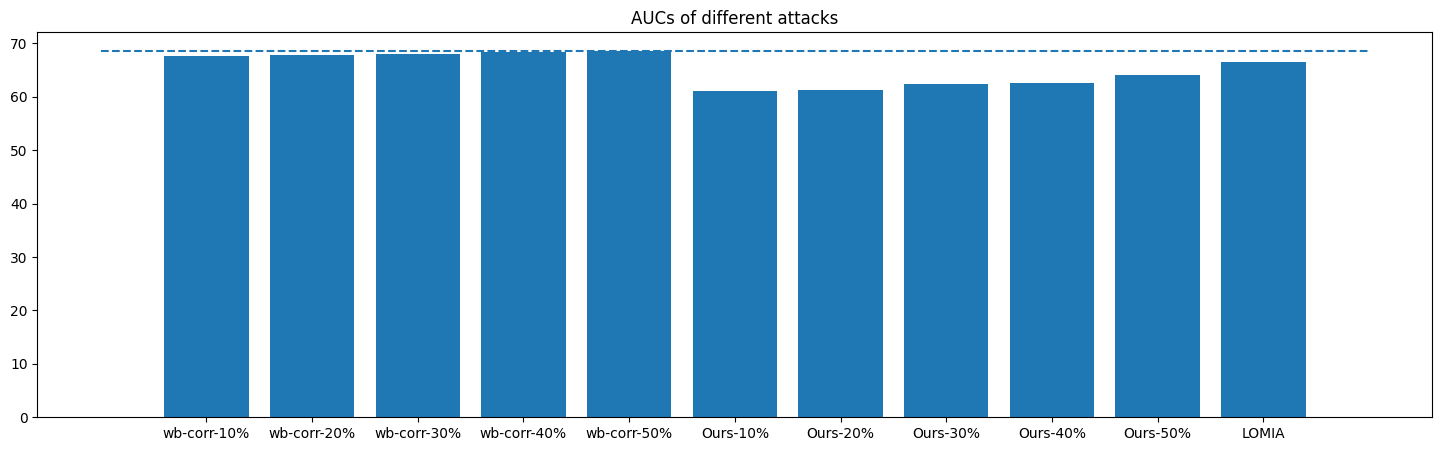

In [18]:
# plot bars with x ticks as names and y as aucs
# make the yticks vertical
plt.figure(figsize=(18,5))
plt.bar(names, np.array(aucs)*100)
plt.hlines(aucs[4]*100, -1, len(names), linestyles='dashed')
plt.title('AUCs of different attacks')
plt.show()

## Subgroup Biased Neuron

In [ ]:
subgroup_columns = ['sex', 'race', 'relig']

subgroup_disparity_dict, subgroup_clfs = improved_subgroup_attack(ds, subgroup_columns, neuron_clfs[0.5], X_neuron, y, metric='accuracy')

print(subgroup_disparity_dict)

# plot_subgroup_disparity(subgroup_disparity_dict, subgroup_columns)

In [6]:
subgroup_columns = ['sex', 'race', 'relig']

subgroup_disparity_dict, subgroup_clfs = improved_subgroup_attack(ds, subgroup_columns, neuron_clfs[0.5], X_neuron, y, metric='auc', dist_percentiles=[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

print(subgroup_disparity_dict)

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


  Subgroup Name Subgroup Value  Original ASR  Improved Attack ASR (0.5)   
0           sex         female     63.185968                  67.404884  \
1           sex           male     63.662695                  68.125871   
2          race          white     64.667707                  68.702694   
3          race          other     57.620321                  59.754826   
4          race          black     61.538332                  59.401441   
5         relig       catholic     61.578453                  60.891219   
6         relig     protestant     66.950352                  69.294720   
7         relig           none     61.143846                  62.269878   

   Improved Attack ASR (0.6)  Improved Attack ASR (0.7)   
0                  65.460153                  63.798397  \
1                  66.494241                  64.928089   
2                  67.037276                  66.270376   
3                  61.637814                  59.054654   
4                  67.867907 

In [7]:
from tabulate import tabulate

table = tabulate(subgroup_disparity_dict, headers='keys', tablefmt='latex_booktabs', showindex=False, floatfmt=".2f")

# print the LaTeX table
print(table)

\begin{tabular}{llrrrrrrrr}
\toprule
 Subgroup Name   & Subgroup Value   &   Original ASR &   Improved Attack ASR (0.5) &   Improved Attack ASR (0.6) &   Improved Attack ASR (0.7) &   Improved Attack ASR (0.8) &   Improved Attack ASR (0.9) &   Improved Attack ASR (0.95) &   Improved Attack ASR (0.99) \\
\midrule
 sex             & female           &          63.19 &                       67.40 &                       65.46 &                       63.80 &                       64.18 &                       63.70 &                        64.94 &                        65.00 \\
 sex             & male             &          63.66 &                       68.13 &                       66.49 &                       64.93 &                       66.74 &                       65.29 &                        65.10 &                        64.69 \\
 race            & white            &          64.67 &                       68.70 &                       67.04 &                       66.27 &      

## Most Discriminative Neuron

In [ ]:
def get_top_dist_indices(ds, conditions, X_neuron, dist_percentile=0.9):
    # normalize X_neuron first
    X_neuron_mean = X_neuron.mean(axis=0)
    X_neuron_std = X_neuron.std(axis=0)
    X_neuron = (X_neuron - X_neuron_mean) / X_neuron_std
    vec = subgroup_vulnerability_distance_vector(ds, conditions, X_neuron)
    # filter out the nan values
    nan_indices = np.argwhere(np.isnan(vec))
    vec = np.delete(vec, nan_indices)
    X_neuron = np.delete(X_neuron, nan_indices, axis=0)
    pos_vec = np.abs(vec)
    sorted_indices = np.argsort(-pos_vec)
    cum_norm = np.array([np.linalg.norm(vec[sorted_indices[:i]]) for i in range(1, len(sorted_indices)+1)])
    cum_norm_p = cum_norm / cum_norm[-1]
    idx = np.argmax(cum_norm_p > dist_percentile)
    top_indices = sorted_indices[:idx]

    return top_indices

In [ ]:
get_top_dist_indices(ds, {'sex':'male'}, x_n_tr)

In [ ]:
male_indices = get_indices_by_conditions(ds, x_n_tr, {'sex': 'male'})
female_indices = get_indices_by_conditions(ds, x_n_tr, {'sex': 'female'})

## Plot subgroup disparity

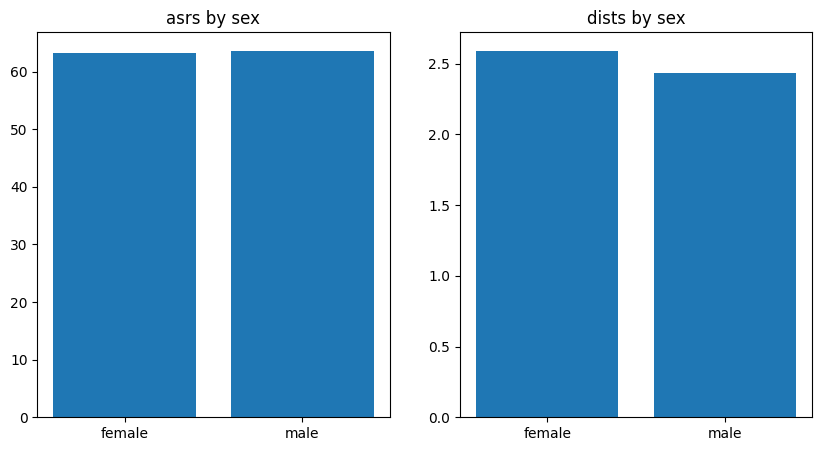

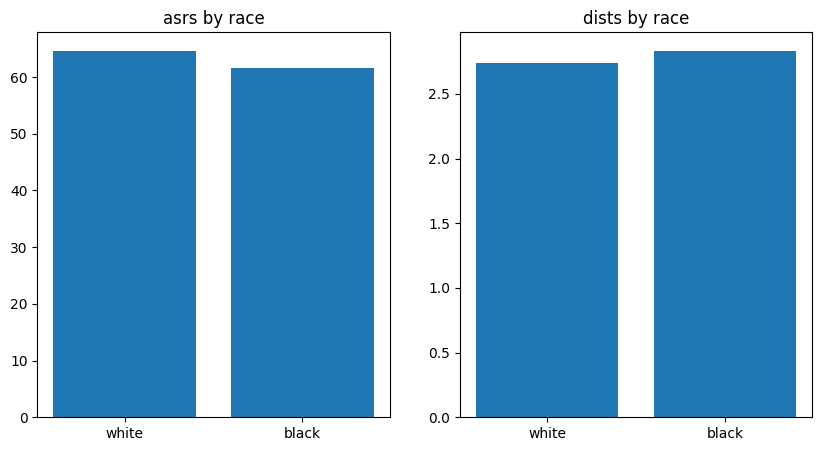

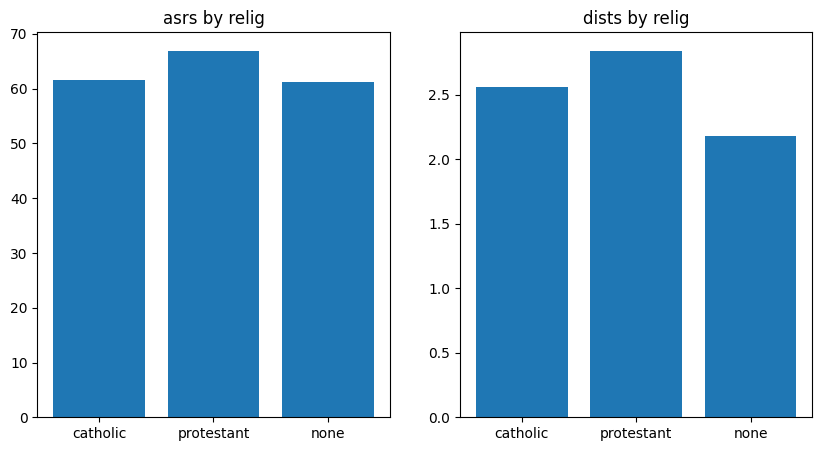

In [9]:
subgroup_columns = ['sex', 'race', 'relig']

# if 'att_enc' not in globals():
#     y_onehot, att_enc = model_utils.get_onehot(y.to_numpy().ravel().reshape(-1,1))
test_size = 0.5

x_n_tr, x_n_te, y_n_tr, y_n_te= train_test_split(X_neuron, y, test_size=test_size, random_state=42)
x_n_tr, x_n_te = data_utils.normalize(x_n_tr, x_n_te)
subgroup_disparity_dict = get_subgroup_disparity(ds, subgroup_columns, neuron_clfs[round(1-test_size,1)], x_n_te, y_n_te, metric='auc')
plot_subgroup_disparity(subgroup_disparity_dict)

invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


{'sex': {'asrs': {'female': 67.48346844995703, 'male': 64.85025207467638}, 'dists': {'female': 0.47285606082663384, 'male': 0.8288567398871771}}, 'race': {'asrs': {'white': 68.5323719683497, 'black': 78.53333333333333}, 'dists': {'white': 0.7485709773756537, 'black': 0.3517112583228034}}, 'relig': {'asrs': {'catholic': 66.02446556965691, 'protestant': 71.35118726389638, 'none': 59.23295454545454}, 'dists': {'catholic': 0.36091806505653895, 'protestant': 0.7454172567814691, 'none': 0.6708013114637875}}}


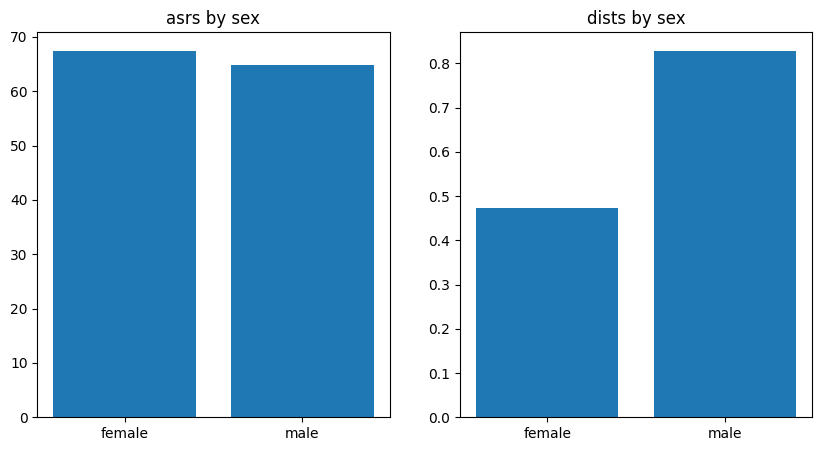

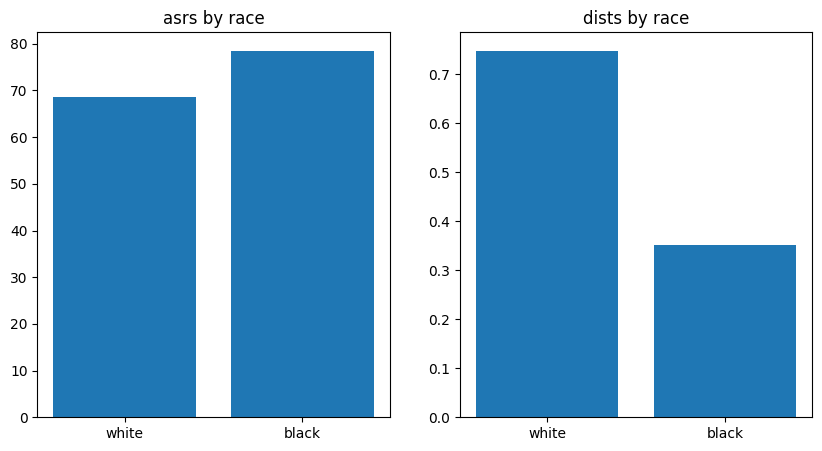

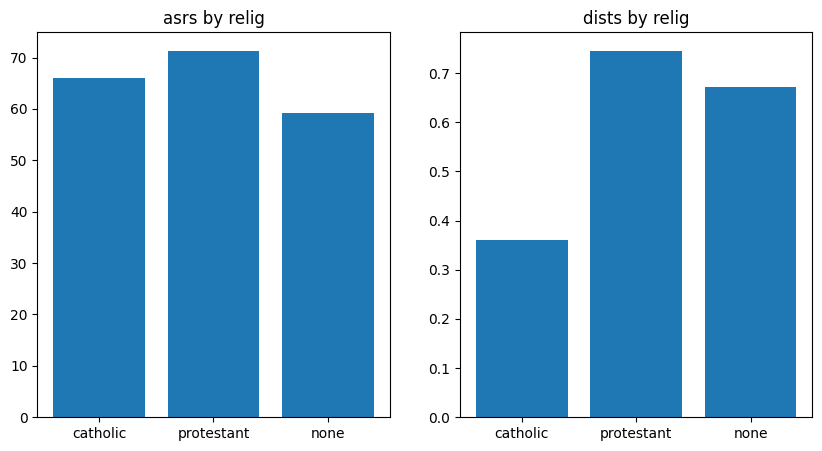

In [16]:
subgroup_columns = ['sex', 'race', 'relig']

# if 'att_enc' not in globals():
#     y_onehot, att_enc = model_utils.get_onehot(y.to_numpy().ravel().reshape(-1,1))
test_size = 0.5

x_n_tr, x_n_te, y_n_tr, y_n_te= train_test_split(X_neuron, y, test_size=test_size, random_state=42)
subgroup_disparity_dict = get_subgroup_disparity_baseline(ds, subgroup_columns, x_n_te, y_n_te, metric='auc')
print(subgroup_disparity_dict)
plot_subgroup_disparity(subgroup_disparity_dict)

In [ ]:
test_indices = np.arange(len(X_neuron))[np.isin(X_neuron, x_n_te)]

## Our attack with random data

In [ ]:
random_df = filter_random_data(ds, clf, num_samples=1000000)
X_random_neuron = make_neuron_output_data(random_df, clf, y_columns)
y_random = random_df[ds.ds.meta['sensitive_column'] + "_" + ds.ds.meta['sensitive_positive']]

In [ ]:
random_neuron_clf = model_utils.get_model(max_iter=500)
y_random_onehot = att_enc.transform(y_random.to_numpy().ravel().reshape(-1,1))
random_neuron_clf.fit(X_random_neuron, y_random_onehot)

In [ ]:
# test on the test data
acc = 100 * random_neuron_clf.score(x_n_te, att_enc.transform(y_n_te.to_numpy().ravel().reshape(-1,1)))
if True:
    print(f"Attack accuracy: {acc}")

In [ ]:
t1 = torch.from_numpy(X_train.iloc[0].to_numpy()).float().to(model_utils.device)
# out_1 = torch.relu(np.matmul(X_train.iloc[0].to_numpy(), clf.coefs_[0]) + clf.intercepts_[0])
out_1 = torch.relu(torch.matmul(t1, torch.from_numpy(clf.coefs_[0]).float().to(model_utils.device)) + torch.from_numpy(clf.intercepts_[0]).float().to(model_utils.device))
print(out_1)
out_2 = (np.matmul(out_1, clf.coefs_[1]) + clf.intercepts_[1])
print(out_2)

# Draft

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
dataset = 'NLSY'

In [ ]:
nlsy_data_dict = {
    'name': "NLSY",
    'path': 'data/nlsy_5096.csv',
    'dummy_columns': ['marital8', 'gender', 'race', 'arrestsdli8', 'drug_marijuana',
        'smoking8', 'drinking8', 'sexdrugsdli8', 'sexstrng8'],
    'numeric_columns': ['age','children', 'incarceration', 'income8'],
    'y_column': 'ratelife8',
    'sensitive_column': 'drug_marijuana',
    'sensitive_pos': 'dm_yes',
    'y_pos': "excellent",
    'attack_type': "Random"
}

In [ ]:
adult_data_dict = {
    'name': "Adult",
    'path': 'data/Adult_35222.csv',
    'dummy_columns': ["work", "education", "marital", "occupation", "race", "sex"],
    'numeric_columns': ["fnlwgt", "capitalgain", "capitalloss", "hoursperweek"],
    'y_column': 'income',
    'sensitive_column': 'marital',
    'sensitive_pos': 'Married',
    'y_pos': ">50K",
    'attack_type': "Random"
}

In [ ]:
gss_data_dict = {
    'name': "GSS",
    'path': 'data/GSS_15235.csv',
    'dummy_columns': ['year', 'marital', 'divorce', 'sex', 'race', 'relig', 'xmovie', 'pornlaw'],
    'numeric_columns': ['childs', 'age', 'educ'],
    'y_column': 'hapmar',
    'sensitive_column': 'xmovie',
    'sensitive_pos': 'x_yes',
    'y_pos': 'nottoohappy',
    "attack_type": "Random"
}

In [ ]:
all_data_dict = {
    "Adult": adult_data_dict,
    "GSS": gss_data_dict,
    "NLSY": nlsy_data_dict
}

In [ ]:
data_dict = all_data_dict[dataset]

In [ ]:
#data = adult_data.data
orig_data = pd.read_csv(data_dict['path'])

In [ ]:
if data_dict['name'] == 'GSS':
    orig_data['pornlaw'] = orig_data['pornlaw'].replace({"illegalillegal8": "illegal"})
elif data_dict['name'] == 'NLSY':
    orig_data = orig_data.drop(['id'], axis=1)

In [ ]:
data = orig_data.copy()

In [ ]:
data

In [ ]:
data.columns

In [ ]:
data_dict

In [ ]:
data = data.dropna()
data = pd.get_dummies(data, columns=data_dict['dummy_columns'])
numerical_features = data_dict['numeric_columns']
scaler = StandardScaler()
scaler.fit(data[numerical_features])
data[numerical_features] = scaler.transform(data[numerical_features])

In [ ]:
def draw_plot(result_df, name, flip_column_different=False, metric="accuracy"):
    if flip_column_different:
        vals = result_df.copy()
        vals.index = vals['Subgroup Name'].values
        vals = vals.drop(['Subgroup Name', 'Count'], axis=1)
        vals = vals.transpose()
        rownames = vals.index.values
    else:
        rownames = result_df['Subgroup Name'].values
        vals = result_df.drop(['Subgroup Name', 'Count'], axis=1)

    x = np.arange(len(rownames))  # convert range to numpy array
    width = len(x) 
    multiplier = 0

    fig, ax = plt.subplots(figsize=(16, 4),layout='constrained')

    tick_locations = []

    for attribute, measurement in vals.items():
        # print(measurement)
        offset = width * 2 * multiplier
        # print(x *10 + offset)
        loc = x * width * 2 + offset
        tick_locations += loc.tolist()
        rects = ax.bar(x * width * 2 + offset, measurement, width, label=attribute)
        # print(rects)
        ax.bar_label(rects, labels=[f"{round(h, 2)}" for h in measurement], padding=3)
        multiplier += width * 1.25
        if multiplier == 1:
            break

    ax.set_ylabel(f'ASR {metric}')
    ax.set_title(f'Disparate Vulnerability {name}')
    ax.set_xticks(tick_locations, rownames.tolist() * vals.shape[1], rotation=90)  # add half width to center the ticks
    if flip_column_different:
        ax.legend(loc='upper left', ncol=3, bbox_to_anchor=(0, 2))
    else:
        ax.legend(loc='upper left', ncol=3, bbox_to_anchor=(0, 1.5))
    ax.set_ylim(0, 1)

    plt.show()

In [ ]:
def get_random_data(num, one_hot_columns, orig_data):
    orig_columns = orig_data.columns
    unique_val_dict = {}
    for col in orig_columns:
        unique_val_dict[col] = orig_data[col].unique()
        if col not in data_dict['dummy_columns'] and col != data_dict['y_column']:
            unique_val_dict[col] = [np.min(unique_val_dict[col]), np.max(unique_val_dict[col])]
    # print(unique_val_dict)
    x = {}
    for col in orig_columns:
        if col in data_dict['dummy_columns'] or col == data_dict['y_column']:
            # print()
            np.random.seed(42)
            x[col] = np.random.choice(unique_val_dict[col].tolist(), num, replace=True)
        else:
            np.random.seed(42)
            # print(unique_val_dict[col][0], unique_val_dict[col][1])
            # x[col] = [random.randint(unique_val_dict[col][0], unique_val_dict[col][1])] * 2
            x[col] = np.random.randint(unique_val_dict[col][0], unique_val_dict[col][1], size=num)
            # x[col] = 0

    # x = pd.DataFrame([x], columns = orig_data.columns)
    x = pd.DataFrame.from_dict(x)
    # print(x)
    xp = x.copy()
    x = pd.get_dummies(x, columns=data_dict['dummy_columns'])
    x = pd.DataFrame(x, columns=one_hot_columns)
    x.fillna(0, inplace=True)
    numerical_features = data_dict['numeric_columns']
    x[numerical_features] = scaler.transform(x[numerical_features])

    return x, xp


In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop(data_dict['y_column'], axis=1)
y = data[data_dict['y_column']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

np.random.seed(42)

# Create an instance of MLPClassifier with random_state set to 42
# clf = MLPClassifier(random_state=42, hidden_layer_sizes=(30, 10, 2))

clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# clf = RandomForestClassifier()
# clf.fit(X_train, y_train)

In [ ]:
score = clf.score(X_test, y_test)
print("Accuracy:", score)

In [ ]:
# Assuming clf is the trained decision tree classifier
predicted_labels = clf.predict(X_test)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
sensitive_attr = data_dict['sensitive_column']
sensitive_columns = list(filter(lambda x: sensitive_attr in x, data.columns))
attr_len = len(sensitive_attr) + 1
sensitive_values = [val[attr_len:] for val in sensitive_columns]

In [ ]:
# random_oh_df, random_df = get_random_data(10000, data.columns, orig_data)
# for _ in range(1):
#     clf.predict([random_oh_df.drop(data_dict['y_column'], axis=1).iloc[0].copy()]* 100000)

In [ ]:
# Random Attack

random_oh_df, random_df = get_random_data(20000, data.columns, orig_data)
X_random = random_oh_df.drop(data_dict['y_column'], axis=1)
default_cols = X_random.columns
# y = random_oh_df[data_dict['y_column']]

prediction_columns = []
for sensitive_value in sensitive_values:
    X_random[sensitive_attr + "_" + sensitive_value] = pd.Series(np.ones(X_random.shape[0]), index=X_random.index)
    for other_value in sensitive_values:
        if other_value != sensitive_value:
            X_random[sensitive_attr + "_" + other_value] = pd.Series(np.zeros(X_random.shape[0]), index=X_random.index)

    newcolname = "prediction_" + sensitive_value
    prediction_columns.append(newcolname)
    X_random[newcolname] = pd.Series(clf.predict(X_random[default_cols]), index=X_random.index)
    X_random["confidence_" + sensitive_value] = pd.Series(np.max(clf.predict_proba(X_random[default_cols]), axis=1), 
                                                         index=X_random.index)

X_random['all_predictions'] = X_random[prediction_columns].apply(pd.Series.unique, axis=1)

# X_random = X_random[X_random['all_predictions'].apply(lambda x: len(x)==len(sensitive_values))]

new_df = None

dfs = []

for sensitive_value in sensitive_values:
    X_temp = X_random[default_cols].copy()

    X_temp[sensitive_attr + "_" + sensitive_value] = pd.Series(np.ones(X_temp.shape[0]), index=X_random.index)
    for other_value in sensitive_values:
        if other_value != sensitive_value:
            X_temp[sensitive_attr + "_" + other_value] = pd.Series(np.zeros(X_temp.shape[0]), index=X_random.index)

    X_temp[data_dict['y_column']] = X_random["prediction_" + sensitive_value]
    X_temp['confidence'] = X_random["confidence_" + sensitive_value]

    dfs.append(X_temp.copy())

random_oh_df = pd.concat(dfs, ignore_index=True)

new_df = random_oh_df.copy()

random_oh_df = random_oh_df[random_oh_df['confidence'].apply(lambda x: x > 0.8)].drop('confidence', axis=1)
# X_test = random_oh_df.drop(data_dict['y_column'], axis=1)
# y_test = random_oh_df[data_dict['y_column']]


In [ ]:
sns.histplot(data=new_df, x='confidence', bins=[i/10 for i in range(11)])

In [ ]:
ax = sns.histplot(data=new_df[new_df[sensitive_attr + "_" + sensitive_values[0]]==1], x='confidence', bins=[i/10 for i in range(11)])
ax.set_xlabel(f'Confidence for {sensitive_values[0]}')
plt.show()

In [ ]:
ax = sns.histplot(data=new_df[new_df[sensitive_attr + "_" + sensitive_values[1]]==1], x='confidence', bins=[i/10 for i in range(11)])
ax.set_xlabel(f'Confidence for {sensitive_values[1]}')
plt.show()

In [ ]:
# # Random Attack

# def get_random_query_data():
#     random_oh_df, random_df = get_random_data(10000, data.columns, orig_data)
#     X_random = random_oh_df.drop(data_dict['y_column'], axis=1)
#     # y = random_oh_df[data_dict['y_column']]



#     # Assuming X_test is the test set and y_test is the true labels
#     attack_dataset = []
#     for i in tqdm(range(len(X_random)), disable=False):
#         # Get the predicted label and true label for this record
#         #pred_label = predicted_labels[i]
#         # true_label = y_test.iloc[i]
        
#         # Check if the predicted label matches the true label for only one possible value of the sensitive attribute
#         num_matches = 0
#         matched_value = None
#         # sensitive_values = ["Married", "Single"]
#         records = []
#         y_preds = []
#         # records = [record.copy() for _ in range(len(sensitive_values))]
#         for sensitive_value in sensitive_values:
#             record = X_random.iloc[i].copy()
#             record[sensitive_attr + "_" + sensitive_value] = 1

#             for other_value in sensitive_values:
#                 if other_value != sensitive_value:
#                     record[sensitive_attr + "_" + other_value] = 0
            
#             # print(record[['marital_Married']])
#             y_pred = clf.predict([record])[0]
#             # probabilities = clf.predict_proba([record])
#             # y_pred = model.predict(record, )
#             # print(clf.predict_proba([record]))
#             # print(y_pred)
#             if y_pred in y_preds:
#                 break
#             else:
#                 y_preds.append(y_pred)
#             record[data_dict['y_column']] = y_pred

#             records.append(record)

#         # print(y_preds)

#         if len(records) != len(sensitive_values):
#             continue
#         else:
#             attack_dataset += records

#     random_oh_df = pd.DataFrame(attack_dataset)

#     return random_oh_df



# if data_dict["attack_type"] == "Random":
#     random_oh_df = get_random_query_data()

#     X_test = random_oh_df.drop(data_dict['y_column'], axis=1)
#     y_test = random_oh_df[data_dict['y_column']]


In [ ]:
# pd.crosstab(random_oh_df['marital_Married'], random_oh_df['income'])

In [ ]:
random_oh_df.shape

In [ ]:
# LOMIA Attack

# Assuming X_test is the test set and y_test is the true labels

attack_dataset = []
for i in tqdm(range(len(X_test))):
    # Get the predicted label and true label for this record
    #pred_label = predicted_labels[i]
    true_label = y_test.iloc[i]
    
    # Check if the predicted label matches the true label for only one possible value of the sensitive attribute
    num_matches = 0
    matched_value = None
    # sensitive_values = ["Married", "Single"]
    for sensitive_value in sensitive_values:
        record = X_test.iloc[i].copy()
        record[sensitive_attr + "_" + sensitive_value] = 1

        for other_value in sensitive_values:
            if other_value != sensitive_value:
                record[sensitive_attr + "_" + other_value] = 0
        
        # Check if the predicted label matches the true label for this sensitive value
        # if clf.predict([record])[0] == true_label:
        if clf.predict(record.to_numpy().reshape(1, -1))[0] == true_label:
            num_matches += 1
            matched_value = sensitive_value
            
    # If there is only one match, label the record with the matched value
    if num_matches == 1:
        record = X_test.iloc[i].copy()
        record[sensitive_attr + "_" + matched_value] = 1

        for other_value in sensitive_values:
            if other_value != matched_value:
                record[sensitive_attr + "_" + other_value] = 0
        
        # record[data_dict['y_column']] = (true_label == data_dict['y_pos'])
        record[data_dict['y_column']] = true_label
        attack_dataset.append(record)


In [ ]:
# Convert the attack dataset to a pandas DataFrame
attack_df = pd.DataFrame(attack_dataset)

unique_values = data[data_dict['y_column']].unique()

# create dictionary to map string values to numeric values
mapping_dict = {value: index for index, value in enumerate(unique_values)}

attack_df[data_dict['y_column']] = attack_df[data_dict['y_column']].map(mapping_dict)

# Split the DataFrame into input and output variables
X_attack = attack_df.drop([sensitive_attr + "_" + val for val in sensitive_values], axis=1) 

# X_attack = attack_df.drop(["marital_Married", "marital_Single"], axis=1) 
# y_attack = attack_df[["marital_Married"]]
y_attack = attack_df[[sensitive_attr + "_" + data_dict['sensitive_pos']]]

In [ ]:
# Assuming X_attack and y_attack are the attack dataset
# attack_model = DecisionTreeClassifier()
# attack_model = MLPClassifier()
attack_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000, random_state=42)
attack_model.fit(X_attack, y_attack)

# from xgboost import XGBClassifier

# attack_model = XGBClassifier()
# attack_model.fit(X_attack, y_attack)

In [ ]:
if isinstance(attack_model, MLPClassifier):
    weights = attack_model.coefs_[0]

    # calculate the absolute values of the weights and sum them across all hidden units
    abs_weights = np.abs(weights)
    feature_importance_scores = abs_weights.sum(axis=1)

    # normalize the feature importance scores
    feature_importance_scores /= feature_importance_scores.sum()

    # print the feature importance scores
    plt.bar(range(len(feature_importance_scores)),feature_importance_scores)

In [ ]:
X_attack.columns

In [ ]:
# Assuming X_test is the original dataset and y_test is the true sensitive attributes (if available)
def preprocess_attack_data(data):
    X = data.drop([sensitive_attr + "_" + val for val in sensitive_values], axis=1)
    y = data[sensitive_attr + "_" + data_dict['sensitive_pos']]

    X[data_dict['y_column']] = X[data_dict['y_column']].map(mapping_dict)

    feature_order = X_attack.columns
    X = X[feature_order]
    missing_value_rows = X.notna().all(axis=1)
    X = X[missing_value_rows]
    y = y[missing_value_rows]
    return X, y

In [ ]:
def preprocess_attack_data_w_high_conf(data):
    X = data.drop([data_dict['y_column']], axis=1)

    columns = X.columns

    data['confidence'] = pd.Series(np.max(clf.predict_proba(data[columns]), axis=1), 
                                                         index=data.index)
    
    data = data[data['confidence']> 0.9].drop(['confidence'], axis=1)

    X = data.drop([sensitive_attr + "_" + val for val in sensitive_values], axis=1)
    y = data[sensitive_attr + "_" + data_dict['sensitive_pos']]

    X[data_dict['y_column']] = X[data_dict['y_column']].map(mapping_dict)

    feature_order = X_attack.columns
    X = X[feature_order]
    missing_value_rows = X.notna().all(axis=1)
    X = X[missing_value_rows]
    y = y[missing_value_rows]
    return X, y

In [ ]:
X, y = preprocess_attack_data(data)
# X, y = preprocess_attack_data_w_high_conf(data)
# random_oh_df = get_random_query_data()
# X, y = preprocess_attack_data(random_oh_df)
# X, y = X_attack, pd.Series(np.array(y_attack).reshape(-1), index=X_attack.index)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score

In [ ]:
def compare(evaluation_metric, flip_column_different, override_flip_vulnerable=None):

    if data_dict['name'] == 'GSS':
        attrs = ["race", "sex", "pornlaw", "relig"]
    elif data_dict['name'] == 'Adult':
        attrs = ["race", "sex", "education"]
    elif data_dict['name'] == 'NLSY':
        attrs = ["race", "gender", "marital8"]

    result_df_dict = {}

    # evaluation_metric = "f1"

    def eval_score(y_test, y_pred):
        if evaluation_metric == "accuracy":
            return accuracy_score(y_test, y_pred)
        elif evaluation_metric == "f1":
            return f1_score(y_test, y_pred)
        elif evaluation_metric == 'precision':
            return precision_score(y_test, y_pred)
        elif evaluation_metric == 'recall':
            return recall_score(y_test, y_pred)
        elif evaluation_metric == "fpr":
            # print(y_test)
            fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), y_pred.to_numpy())
            auc_score = roc_auc_score(y_test.to_numpy(), y_pred.to_numpy())
            return fpr[1]  # FPR at a fixed TPR of 0.5

    flip_column_different = flip_column_different

    if data_dict['name'] == "NLSY":
        flip_column = "marital8"
        flip_vulnerable = "nevermarried"
    elif data_dict['name'] == "GSS":
        flip_column = "pornlaw"
        flip_vulnerable = "legal"

    if override_flip_vulnerable is not None:
        flip_vulnerable = override_flip_vulnerable

    flip_columns = list(filter(lambda x: flip_column in x, X.columns))
    flip_target = flip_column + "_" + flip_vulnerable

    for attr in attrs:

        # attr = "race"

        attr_columns = list(filter(lambda x: attr in x, X.columns))

        attr_column_indices = {}

        for col in attr_columns:
            attr_column_indices[col] = (X[col]==1).to_numpy()

        attr_name_len = len(list(attr_column_indices.keys())[0].split("_")[0]) + 1
        rows= []
        for col in attr_column_indices:
            row_dict = {}
            row_dict['Subgroup Name'] = col[attr_name_len:]
            indices = attr_column_indices[col]

            row_dict['Count'] = sum(indices)

            X_subset = X[indices].copy()
            Y_subset = y[indices].copy()

            predicted_sensitive_attributes = attack_model.predict(X_subset)
            
            correct_indices_0 = (predicted_sensitive_attributes == Y_subset).to_numpy()    

            # accuracy = sum(predicted_sensitive_attributes == Y_subset) / len(Y_subset)
            accuracy = eval_score(Y_subset, predicted_sensitive_attributes)
            #print(f'{col} {accuracy}')
            row_dict['Original ASR'] = accuracy

            if flip_column_different:
                X_subset_p = X_subset.copy()
                for col in flip_columns:
                    if col == flip_target:
                        X_subset_p[col] = 1
                    else:
                        X_subset_p[col] = 0

                predicted_sensitive_attributes = attack_model.predict(X_subset_p)

                # accuracy = sum(predicted_sensitive_attributes == Y_subset) / len(Y_subset)
                accuracy = eval_score(Y_subset, predicted_sensitive_attributes)
                #print(f'{col} {col2} {accuracy}')
                row_dict[f'ASR after {flip_column} flipped to {flip_vulnerable}'] = accuracy
            else:
                for col2 in attr_column_indices:
                    if col2 != col or True:
                        X_subset_p = X_subset.copy()
                        X_subset_p[col2] = 1
                        
                        for col3 in attr_column_indices:
                            if col3 != col2:
                                X_subset_p[col3] = 0

                        predicted_sensitive_attributes = attack_model.predict(X_subset_p)

                        # accuracy = sum(predicted_sensitive_attributes == Y_subset) / len(Y_subset)
                        accuracy = eval_score(Y_subset, predicted_sensitive_attributes)
                        #print(f'{col} {col2} {accuracy}')
                        row_dict[f'ASR after value flipped to {col2[attr_name_len:]}'] = accuracy


            column1 = pd.Categorical(X_subset[data_dict['y_column']])
            column2 = pd.Categorical(Y_subset)
            # print(pd.crosstab(column1, column2))

            # row_dict['Subgroup pickmax ratio'] = pd.crosstab(column1, column2).to_numpy().max(axis=1).sum()/X_subset.shape[0]

            rows.append(row_dict)

        result_df = pd.DataFrame(rows)

        result_df_dict[attr] = result_df

    for attr in result_df_dict:
        print(result_df_dict[attr][['Subgroup Name', 'Count']])
        draw_plot(result_df_dict[attr], attr, flip_column_different=flip_column_different, metric=evaluation_metric)


In [ ]:
compare('f1', True)

In [ ]:
import shap

X_temp, y_temp = preprocess_attack_data(data)

# explainer = shap.Explainer(attack_model, X_temp)

In [ ]:
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense


# Extract the weights and biases of the MLPClassifier
weights = attack_model.coefs_
biases = attack_model.intercepts_

# Create a Keras neural network with the same architecture as the MLPClassifier
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_temp.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Set the weights and biases of the Keras neural network to be equal to the MLPClassifier
model.layers[0].set_weights([weights[0], biases[0]])
model.layers[1].set_weights([weights[1], biases[1]])
model.layers[2].set_weights([weights[2], biases[2]])


In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_attack, y_attack)

In [ ]:
import shap
explainer = shap.Explainer(model, X_temp.astype('float64'))

In [ ]:
sample_idx = 0
sample = X_attack.iloc[sample_idx]
shap_values = explainer.shap_values(sample)

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X_attack)

# visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

In [ ]:
# shap.summary_plot(shap_values, X_attack.iloc[:,:], plot_type="layered_violin", color='coolwarm')
shap.summary_plot(shap_values, X_attack.iloc[:,:], plot_type="violin")

In [ ]:
shap.plots.waterfall(shap_values[0], max_display=X_attack.shape[0])

In [ ]:
import xgboost
import shap

# train xgboost model on diabetes data:
X1, y1 = shap.datasets.diabetes()
# bst = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

In [ ]:
xgboost.DMatrix(X1, label=y1).get_label()

In [ ]:
shap_values[0]

In [ ]:
def f(X):
    return attack_model.predict([X[:,i] for i in range(X.shape[1])]).flatten()

In [ ]:
explainer = shap.KernelExplainer(f, X_attack.iloc[:50,:])
shap_values = explainer.shap_values(X_attack.iloc[299,:], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values, X_attack.iloc[299,:])

In [ ]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

In [ ]:
X

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
for attr in result_df_dict:
    print(result_df_dict[attr][['Subgroup Name', 'Count']])
    draw_plot(result_df_dict[attr], attr)

In [ ]:
for attr in result_df_dict:
    print(result_df_dict[attr][['Subgroup Name', 'Count']])
    draw_plot(result_df_dict[attr], attr)

In [ ]:
for attr in result_df_dict:
    print(result_df_dict[attr])

In [ ]:
def draw_plot(result_df, name):
    rownames = result_df['Subgroup Name'].values
    vals = result_df.drop(['Subgroup Name', 'Count'], axis=1)

    x = np.arange(len(rownames))  # convert range to numpy array
    width = len(x) 
    multiplier = 0

    fig, ax = plt.subplots(figsize=(16, 4),layout='constrained')

    tick_locations = []

    for attribute, measurement in vals.items():
        # print(measurement)
        offset = width * 2 * multiplier
        # print(x *10 + offset)
        loc = x * width * 2 + offset
        tick_locations += loc.tolist()
        rects = ax.bar(x * width * 2 + offset, measurement, width, label=attribute)
        # print(rects)
        ax.bar_label(rects, labels=[f"{round(h, 2)}" for h in measurement], padding=3)
        multiplier += width * 1.25
        if multiplier == 1:
            break

    ax.set_ylabel('ASR')
    ax.set_title(f'Disparate Vulnerability {name}')
    ax.set_xticks(tick_locations, rownames.tolist() * vals.shape[1], rotation=90)  # add half width to center the ticks
    ax.legend(loc='upper left', ncol=3, bbox_to_anchor=(0, 1.5))
    ax.set_ylim(0, 1)

    plt.show()

In [ ]:
attack_df.shape

In [ ]:
for attr in result_df_dict:
    print(result_df_dict[attr][['Subgroup Name', 'Count']])
    draw_plot(result_df_dict[attr], attr)

In [ ]:
for attr in result_df_dict:
    draw_plot(result_df_dict[attr], attr)

In [ ]:
predicted_sensitive_attributes = attack_model.predict(X)
accuracy = sum(predicted_sensitive_attributes == y) / len(y)
print("Attack model accuracy:", accuracy)

In [ ]:
attack_success_rates = []

for idx, indices in enumerate([male_indices, female_indices]):
    X_subset = X[indices].copy()
    Y_subset = y[indices].copy()

    # X_subset['income'] = 0
    predicted_sensitive_attributes = attack_model.predict(X_subset)
    correct_indices_0 = (predicted_sensitive_attributes == Y_subset).to_numpy()

    # X_subset['income'] = 1 - X_subset['income']
    X_subset['sex_Male'] = 1 - X_subset['sex_Male']
    X_subset['sex_Female'] = 1 - X_subset['sex_Female']
    predicted_sensitive_attributes = attack_model.predict(X_subset)
    correct_indices_1 = (predicted_sensitive_attributes == Y_subset).to_numpy()

    accuracy = sum(predicted_sensitive_attributes == Y_subset) / len(Y_subset)
    attack_success_rates.append(accuracy)
    # print("Attack model accuracy:", accuracy)

    


In [ ]:
male_indices = (X['sex_Male'] == 1).to_numpy()
female_indices = (X['sex_Female'] == 1).to_numpy()

In [ ]:
high_income_indices = (X['income']==1).to_numpy()
low_income_indices = (X['income']==0).to_numpy()

In [ ]:
married_indices = (y==1).to_numpy()
single_indices = (y==0).to_numpy()

In [ ]:
np.logical_and(female_indices, np.logical_or(np.logical_and(married_indices, high_income_indices), np.logical_and(single_indices, low_income_indices))).sum()/female_indices.sum()

In [ ]:
np.logical_and(male_indices, np.logical_or(np.logical_and(married_indices, high_income_indices), np.logical_and(single_indices, low_income_indices))).sum()/male_indices.sum()

In [ ]:
np.logical_and(female_indices, low_income_indices).sum()/female_indices.sum()

In [ ]:
np.logical_and(male_indices, low_income_indices).sum()/male_indices.sum()

In [ ]:
X[male_indices]

In [ ]:
attack_success_rates = []

for indices in [male_indices, female_indices]:
    predicted_sensitive_attributes = attack_model.predict(X[indices])
    accuracy = sum(predicted_sensitive_attributes == y[indices]) / len(y[indices])
    attack_success_rates.append(accuracy)
    # print("Attack model accuracy:", accuracy)

In [ ]:
import matplotlib.pyplot as plt

# Create the data
subgroups = ["Male", "Female"]


# Create the bar plot
plt.bar(subgroups, attack_success_rates)

for i, rate in enumerate(attack_success_rates):
    plt.text(i, rate + 0.01, f"{rate:.2f}", ha="center")

# Set the labels
plt.xlabel("Subgroup")
plt.ylabel("Attack Success Rate")
plt.ylim(0, np.max(attack_success_rates) + 0.2)
plt.title("Bar Plot of Attack Success Rates by Subgroup")

# Show the plot
plt.show()

In [ ]:
attack_success_rates = []

for idx, indices in enumerate([male_indices, female_indices]):
    X_subset = X[indices].copy()
    Y_subset = y[indices].copy()

    # X_subset['income'] = 0
    predicted_sensitive_attributes = attack_model.predict(X_subset)
    correct_indices_0 = (predicted_sensitive_attributes == Y_subset).to_numpy()

    # X_subset['income'] = 1 - X_subset['income']
    X_subset['sex_Male'] = 1 - X_subset['sex_Male']
    X_subset['sex_Female'] = 1 - X_subset['sex_Female']
    predicted_sensitive_attributes = attack_model.predict(X_subset)
    correct_indices_1 = (predicted_sensitive_attributes == Y_subset).to_numpy()

    accuracy = sum(predicted_sensitive_attributes == Y_subset) / len(Y_subset)
    attack_success_rates.append(accuracy)
    # print("Attack model accuracy:", accuracy)


In [ ]:
import matplotlib.pyplot as plt

# Create the data
subgroups = ["Male Records\n With Gender Flipped\n to Female", "Female Records\n With Gender Flipped\n to Male"]


# Create the bar plot
plt.bar(subgroups, attack_success_rates)

for i, rate in enumerate(attack_success_rates):
    plt.text(i, rate + 0.01, f"{rate:.2f}", ha="center")

# Set the labels
plt.xlabel("Subgroup")
plt.ylabel("Attack Success Rate")
plt.ylim(0, np.max(attack_success_rates) + 0.2)
plt.title("Bar Plot of Attack Success Rates by Subgroup")

# Show the plot
plt.show()

In [ ]:
attack_success_rates = []
for idx, indices in enumerate([male_indices, female_indices]):
    X_subset = X[indices].copy()
    Y_subset = y[indices].copy()

    # X_subset['income'] = 0
    predicted_sensitive_attributes = attack_model.predict(X_subset)
    correct_indices_0 = (predicted_sensitive_attributes == Y_subset).to_numpy()

    X_subset['income'] = 1 - X_subset['income']
    # X_subset['sex_Male'] = 1 - X_subset['sex_Male']
    # X_subset['sex_Female'] = 1 - X_subset['sex_Female']
    predicted_sensitive_attributes = attack_model.predict(X_subset)
    correct_indices_1 = (predicted_sensitive_attributes == Y_subset).to_numpy()

    accuracy = sum(predicted_sensitive_attributes == Y_subset) / len(Y_subset)
    # print("Attack model accuracy:", accuracy)
    attack_success_rates.append(accuracy)

In [ ]:
import matplotlib.pyplot as plt

# Create the data
subgroups = ["Male Records\n With Income Flipped\n from Orig. Value", "Female Records\n With Income Flipped\n from Orig. Value"]

# Create the bar plot
plt.bar(subgroups, attack_success_rates)

for i, rate in enumerate(attack_success_rates):
    plt.text(i, rate + 0.01, f"{rate:.2f}", ha="center")

# Set the labels
plt.xlabel("Subgroup")
plt.ylabel("Attack Success Rate")
plt.ylim(0, np.max(attack_success_rates) + 0.2)
plt.title("Bar Plot of Attack Success Rates by Subgroup")

# Show the plot
plt.show()

In [ ]:
correct_indices_inverted.to_numpy()

In [ ]:
import random

In [ ]:
idx = random.randInt()
record = X.iloc[]

In [ ]:
for i in range(100):
    for group in ['sex', 'race', 'work', 'occupation']:
        idx = 52
        print(attack_model.predict([X.loc[idx]]))

        group_columns = [c for c in X.columns if c.startswith(group)]
        max_column = np.random.choice(X[group_columns].idxmax(axis=1))
        X.loc[idx, group_columns] = 0
        X.loc[idx, max_column] = 1
        print(attack_model.predict([X.loc[idx]]))


In [ ]:
print(attack_model.predict([X.loc[idx]]))